In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Анализ характеристик тандемной сети с помощью аппроксимации выходных потоков

Исследуем различные методы расчета **межконцевых задержек** и **вероятностей потери** пакетов в тандемных сетях с узлами MAP/PH/1/N. 

В этом ноутбуке мы изучим три способа расчета характеристик тандемной сети с узлами MAP/PH/1/N:

- точный расчет;
- расчет с аппроксимацией выходящих потоков;
- расчет методом Монте-Карло.


Проведем два эксперимента:

1) Проверим точность приближенных методов сравнением с точным решением. Так как точное решение сложно получить, когда входящий MAP, время обслуживания PH, очередь и сама сеть имеют большие размеры, то отдельно рассмотрим:

- произвольные MAP-ы, PH-распределения и длины очередей, но с не одной, двумя или тремя станциями в сети
- простейшие MAP-потоки и PH-распределения (то есть экспоненты) и малые длины очередей (до двух), но с большим числом станций в сети

2) Сравним точность и время расчета имитационной модели и метода аппроксимации выходных потоков на сетях большого размера.

In [80]:
from matplotlib import pyplot as plt, cm
from matplotlib.lines import Line2D
import matplotlib
import numpy as np
from itertools import product
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
from typing import Optional
import os
from time import perf_counter
from dataclasses import dataclass

from pyqumo.fitting import fit_mern2, fit_acph2, fit_map_horvath05
from pyqumo.stats import get_cv, get_skewness, get_noncentral_m2, get_noncentral_m3
from pyqumo.random import PhaseType, Distribution, HyperErlang
from pyqumo.arrivals import MarkovArrival
from pyqumo.errors import BoundsError
from pyqumo.queues import MapPh1NQueue

%matplotlib inline
CMAP_NAME = 'viridis'
CMAP = cm.get_cmap(CMAP_NAME)
LIGHT_CMAP = cm.get_cmap("Pastel2")

tqdm.pandas()  # Делаем доступными функции типа df.progress_apply()

In [81]:
def get_color(x: float, cmap_name: str = CMAP_NAME):
    """
    Получить цвет из текущей карты.
    """
    return cm.get_cmap(cmap_name)(x)

## Генерация случайных параметров

Нам потребуется три набора данных:

- `SMALL_NETS_INPUTS`: сети малого размера, но с произвольными MAP-потоками, PH-распределениями, размерами очередей
- `BASIC_NODES_INPUTS`: сети большого размера, но с элементарными MAP-потоками и PH-распределениями и очередями малого размера
- `RANDOM_NETS_INPUTS`: сети произвольного размера с произвольными очередями, MAP-потоками и PH-распределениями

Параметры будем выбирать следующим образом:

- Средний интервал между поступлениями пакетов всегда равняется 1
- Средняя интенсивность обслуживания варьируется от 0.5 пакета в секунду до 10
- Коэффициент вариации $c$ (и поступлений, и обслуживаний) для `BASIC_NODES_INPUTS` равен 1, а для остальных - случайный, от 0.5 до 4
- Коэффициент ассиметрии $\gamma$ (и поступлений, и обслуживаний) для `BASIC_NODES_INPUTS` равен 2, а для остальных - случайный от $c - 1/c$ до 6
- Коэффициент автокорреляции $\rho_1$ интервалов с лагом 1 во входящем потоке для `BASIC_NODES_INPUT` равен 0, а для остальных - случайный, от -0.01 до 0.3
- Емкость очереди для `BASIC_NODES_INPUT` меняется от 0 до 2, для `SMALL_NETS_INPUTS` меняется от 0 до 5, для `RANDOM_NETS_INPUTS` - от 0 до 10
- Размер сети для `SMALL_NETS_INPUTS` меняется от 1 до 3, для остальных - от 1 до 10 

In [82]:
ARRIVAL_RATE = 1
MIN_BUSY = 0.1
MAX_BUSY = 2.0
MIN_CV = 0.5
MAX_CV = 4.0
MAX_SKEW = 6.0
MIN_LAG = -0.01
MAX_LAG = 0.3
MAX_NET_SIZE = 5
MAX_NET_SIZE__SMALL = 2
MAX_NET_SIZE__BASIC = 5
MAX_CAPACITY = 10
MAX_CAPACITY__SMALL = 2
MAX_CAPACITY__BASIC = 2

INPUT_CSV_FILE = os.path.join('data', '1.1_inputs.csv')

NUM_SAMPLES_PER_SIZE = 30

MAX_ORDER = 10

FORCE_COMPUTE = True

Определим вспомогательные функции, которые будут генерировать случайные MAP-потоки и PH-распределения, используя введенные ограничения.

Будем отслеживать, чтобы все распределения имели порядок, не больший, чем `MAX_ORDER`. Это оказывается важнее, чем точное соответствие моментов, так как длительность расчета из-за большой размерности может стать совсем неприемлемой.

In [83]:
def _build_random_ph(m1: float) -> PhaseType:
    """
    Generate random parameters for PH distribution and build it.
    If the generated PH has too large order, then make it smaller,
    up to `max_order`.
    """
    cv = np.random.uniform(MIN_CV, MAX_CV)
    skew = np.random.uniform(cv - 1/cv, MAX_SKEW)
    moments = np.asarray([m1, get_noncentral_m2(m1, cv), get_noncentral_m3(m1, cv, skew)])
    try:
        dist: Distribution = fit_acph2(moments, strict=True)[0]
    except BoundsError:
        dist: Distribution = fit_mern2(moments, strict=False, max_shape_inc=1)[0]
        if dist.order > MAX_ORDER:
            bad_dist = dist  # store distribution
            # If order is too large, we won't try to tune CV or skew.
            # Instead, we select a random shape and scale rate and shape.
            new_shapes = np.random.randint(MAX_ORDER // 4, MAX_ORDER // 2 + 1, 2)
            k = new_shapes.astype(np.float32) / bad_dist.shapes
            dist = HyperErlang(
                shapes=new_shapes,
                params=(bad_dist.params * k),
                probs=bad_dist.probs
            )
            # Check the new distribution has good enough rate:
            if (err := abs(dist.rate - bad_dist.rate) / bad_dist.rate) > .01:
                print(f"!!! old rate was {bad_dist:.3f}, new rate is {dist.rate:.3f} [error = {err:.3f}]")
                assert False
    return dist.as_ph().scale(dist.mean / m1)


def _build_random_map() -> MarkovArrival:
    """
    Generate random parameters for MAP and build it.
    If the generated MAP is too large, reduce it.
    No gurantee that actual parameters will be as randomly chosen, but who cares :)
    """
    ph = _build_random_ph(ARRIVAL_RATE)
    lag = np.random.uniform(MIN_LAG, MAX_LAG)
    arrival = fit_map_horvath05(ph, lag, n_iters=3)[0]
    return arrival.scale(1 / ARRIVAL_RATE)


def build_random_arrival_and_service():
    """
    Generate random MAP and service-time PH, such that:
    - busy rate is between MIN_BUSY and MAX_BUSY
    - for both MAP and PH, cv is between MIN_CV and MAX_CV
    - for both MAP and PH, skew is bewtween (cv - 1/cv) and MAX_SKEW
    - for MAP, its lag-1 autocorrelation is between LAG_MIN and LAG_MAX
    - for both MAP and PH, their order is no more than MAX_ORDER
    """
    desired_busy = np.random.uniform(MIN_BUSY * 1.001, MAX_BUSY * 0.999)
    mean_service = desired_busy / ARRIVAL_RATE
    real_busy = 0.0
    # Sometimes, due to floating point precision, means and busy rates
    # gets somewhat above or below expected. The following loop prevents 
    # that.
    while real_busy < MIN_BUSY or real_busy > MAX_BUSY:
        arrival = _build_random_map()
        service = _build_random_ph(mean_service)
        real_busy = service.mean / arrival.mean
    return arrival, service

Определим две функции для построения случайных входных данных:

- `random_inputs()`: генерирует случайные входные параметры для моделей `SMALL_NET` и `RANDOM_NET` с заданным ограничением на размер сети и емкость очереди
- `random_basic_inputs()`: генерирует случайные входные параметры для модели `BASIC_NET` (экспоненциальные распределения)

In [84]:
def random_inputs():
    """
    Build random inputs for generic networks.
    """    
    # Define size parameters grid
    net_size_range = range(1, MAX_NET_SIZE + 1)
    samples_range = range(NUM_SAMPLES_PER_SIZE)
    grid = tuple(product(net_size_range, samples_range))
    
    # Build samples
    dataset = []
    for net_size, _ in tqdm(grid):
        arrival, service = build_random_arrival_and_service()
        capacity = np.random.randint(0, MAX_CAPACITY + 1)
        is_small = (capacity <= MAX_CAPACITY__SMALL and 
                    net_size <= MAX_NET_SIZE__SMALL)
        dataset.append({
            'arrival': arrival, 
            'service': service, 
            'capacity': capacity,
            'net_size': net_size,
            'intype': 'generic',
            'small': is_small,
        })
    return dataset


def random_basic_inputs():
    """
    Build random inputs for BASIC_NET.
    Since arrivals and services are almost fixed here, we variate $rho = m_s / m_a$
    with fixed interval for each queue size, and such grid will contain at least
    five points (at most, `NUM_SAMPLES_PER_NET_SIZE // (BASIC_MAX_CAPACITY + 1)`).
    """
    num_points_per_queue = max(
        NUM_SAMPLES_PER_SIZE // (MAX_CAPACITY__BASIC + 1),
        5  # minimum number of busy rates (not exactly busy rate, but it would be for M/M/1 :)
    )    
    service_rates = ARRIVAL_RATE / np.linspace(MIN_BUSY, MAX_BUSY, num_points_per_queue)
    arrival = MarkovArrival.poisson(ARRIVAL_RATE)
    services = [PhaseType.exponential(service_rate) for service_rate in service_rates]
    
    dataset = []
    net_size_range = range(1, MAX_NET_SIZE__BASIC + 1)
    capacity_range = range(MAX_CAPACITY__BASIC + 1)
    grid = tuple(product(net_size_range, capacity_range, services))
    
    for net_size, capacity, service in tqdm(grid):
        is_small = (capacity <= MAX_CAPACITY__SMALL and 
                    net_size <= MAX_NET_SIZE__SMALL)
        dataset.append({
            'arrival': arrival,
            'service': service,
            'capacity': capacity,
            'net_size': net_size,
            'intype': 'basic',
            'small': is_small,
        })
    return dataset

Так как мы не хотим каждый раз генерировать выборку, то будем сохранять ее в CSV-файл, и затем загружать данные из него.

> Если нужно пересчитать, то устанавливаем флаг `FORCE_COMPUTE = True` в определении констант наверху.

Запись и загрузка производится обычными средствами Pandas. Единственная особенность - нужно корректно загружать массивы NumPy.
Для этого определим функцию `parse_numpy_array()`, которая принимает на вход строку и размерность нужной матрицы (вектора, тензора..) и возвращает `numpy.ndarray`.

In [85]:
# Сначала определим вспомогательную функцию, которая разбирает строку
# в массив numpy.ndarray
def parse_numpy_array(s: str, n_dims: int = 2) -> np.ndarray:
    """
    Разбирает двумерный массив из того формата, в котором Pandas
    сохраняет ячейку с ndarray, то есть '[[1 2]\n [3 4]]'
    """
    s = s.replace('\n', '').replace('[', '').replace(']', '')
    a = np.fromstring(s, sep=' ')  # вектор, содержащий N^2 элементов
    n = int(len(a)**(1/n_dims))
    return a.reshape((n,)*n_dims)
    

# Если ROCE_COMPUTE = False, то загружаем выборку из CSV-файла.
if not FORCE_COMPUTE:
    input_data = pd.read_csv(INPUT_CSV_FILE, converters={
        'arrival_d0': parse_numpy_array,
        'arrival_d1': parse_numpy_array,
        'service_s': parse_numpy_array,
        'service_p': (lambda s: parse_numpy_array(s, n_dims=1)),
    })
    input_data['arrival'] = input_data.apply(
        lambda row: MarkovArrival(row.arrival_d0, row.arrival_d1), axis=1)
    input_data['service'] = input_data.apply(
        lambda row: PhaseType(row.service_s, row.service_p), axis=1)
    input_data = input_data.drop(
        ['arrival_d0', 'arrival_d1', 'service_s', 'service_p'], axis=1)
    print(
        f"= loaded {len(input_data)} samples."
        f"If you want to re-generate, set FORCE_COMPUTE = True.")

# Если FORCE_COMPUTE = True, то генерируем новую выборку и сохраняем
# ее в CSV-файл.
else:
    all_samples = []
    print("* generating basic samples")
    all_samples.extend(random_basic_inputs())
    print("* generating generic samples")
    all_samples.extend(random_inputs())
    print(f"= generated {len(all_samples)} samples")
    
    # Добавляем колонки:
    for sample in all_samples:
        arrival = sample['arrival']
        service = sample['service']
        sample.update({
            'arrival_mean': arrival.mean,
            'arrival_rate': 1 / arrival.mean,
            'arrival_std': arrival.std,
            'arrival_cv': arrival.cv,
            'arrival_skew': arrival.skewness,
            'arrival_lag1': arrival.lag(1),
            'service_mean': service.mean,
            'service_rate': 1 / service.mean,
            'service_std': service.std,
            'service_cv': service.cv,
            'service_skew': service.skewness,
            'busy': service.mean / arrival.mean,
            # Эти колонки мы позже удалим - они нужны для сохранения в CSV
            'arrival_d0': arrival.d0,
            'arrival_d1': arrival.d1,
            'service_s': service.s,
            'service_p': service.p,
        })
    
    input_data = pd.DataFrame(all_samples)
    
    # Сохраняем в CSV:
    (input_data
     .drop(['arrival', 'service'], axis=1)
     .to_csv(INPUT_CSV_FILE, index=False))
    
    # Больше эти колонки нам не нужны, удалям:
    input_data = input_data.drop(
        ['arrival_d0', 'arrival_d1', 'service_s', 'service_p'],
        axis=1)

print(input_data.dtypes)
input_data.sample(10)

* generating basic samples


  0%|          | 0/150 [00:00<?, ?it/s]

* generating generic samples


  0%|          | 0/150 [00:00<?, ?it/s]

= generated 300 samples
arrival          object
service          object
capacity          int64
net_size          int64
intype           object
small              bool
arrival_mean    float64
arrival_rate    float64
arrival_std     float64
arrival_cv      float64
arrival_skew    float64
arrival_lag1    float64
service_mean    float64
service_rate    float64
service_std     float64
service_cv      float64
service_skew    float64
busy            float64
dtype: object


,arrival,service,capacity,net_size,intype,small,arrival_mean,arrival_rate,arrival_std,arrival_cv,arrival_skew,arrival_lag1,service_mean,service_rate,service_std,service_cv,service_skew,busy
235,"(MAP: d0=[[-197, 197, 0, 0, 0, 0, 0, 0, 0, 0],...","(PH: s=[[-44.7, 44.7, 0, 0, 0, 0], [0, -44.7, ...",2,3,generic,False,0.998260,1.001743,3.445353,3.451358,3.949551,6.259569e-02,1.754211,0.570057,6.638672,3.784420,4.799146,1.757269
101,"(MAP: d0=[[-1]], d1=[[1]])","(PH: s=[[-3.21]], p=[1])",1,4,basic,False,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000e+00,0.311111,3.214286,0.311111,1.000000,2.000000,0.311111
216,"(MAP: d0=[[-0.222, 0.222], [0, -6.09]], d1=[[2...","(PH: s=[[-6.34, 6.34, 0, 0, 0, 0, 0, 0], [0, -...",7,3,generic,False,0.999994,1.000006,2.619711,2.619725,4.681255,4.145575e-06,0.870652,1.148564,0.805529,0.925202,3.010502,0.870657
111,"(MAP: d0=[[-1]], d1=[[1]])","(PH: s=[[-3.21]], p=[1])",2,4,basic,False,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000e+00,0.311111,3.214286,0.311111,1.000000,2.000000,0.311111
129,"(MAP: d0=[[-1]], d1=[[1]])","(PH: s=[[-0.5]], p=[1])",0,5,basic,False,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000e+00,2.000000,0.500000,2.000000,1.000000,2.000000,2.000000
225,"(MAP: d0=[[-16.6, 16.6, 0, 0], [0, -16.6, 0, 0...","(PH: s=[[-1.23e+03, 1.23e+03, 0, 0, 0, 0, 0, 0...",8,3,generic,False,0.997245,1.002763,3.902623,3.913404,5.870762,1.088544e-01,0.187367,5.337128,0.270273,1.442481,1.421068,0.187884
280,"(MAP: d0=[[-3.44e+03, 3.44e+03, 0, 0, 0, 0, 0,...","(PH: s=[[-6.58e+05, 6.58e+05, 0, 0, 0, 0, 0, 0...",0,5,generic,False,0.999938,1.000062,3.702188,3.702418,4.149355,7.877507e-02,1.274461,0.784645,3.653243,2.866499,3.238994,1.274541
278,"(MAP: d0=[[-1.49e+04, 1.49e+04, 0, 0, 0, 0], [...","(PH: s=[[-25.4, 25.4, 0, 0, 0, 0, 0, 0, 0, 0],...",0,5,generic,False,1.000000,1.000000,1.819246,1.819246,2.041275,1.027474e-08,0.674034,1.483605,0.651632,0.966764,1.243555,0.674034
43,"(MAP: d0=[[-1]], d1=[[1]])","(PH: s=[[-1.36]], p=[1])",1,2,basic,True,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000e+00,0.733333,1.363636,0.733333,1.000000,2.000000,0.733333
226,"(MAP: d0=[[-222, 222, 0, 0, 0, 0, 0], [0, -222...","(PH: s=[[-103, 103, 0, 0], [0, -103, 0, 0], [0...",5,3,generic,False,1.000228,0.999772,3.221189,3.220455,3.592203,5.641625e-02,1.595400,0.626802,5.368197,3.364796,4.453635,1.595036


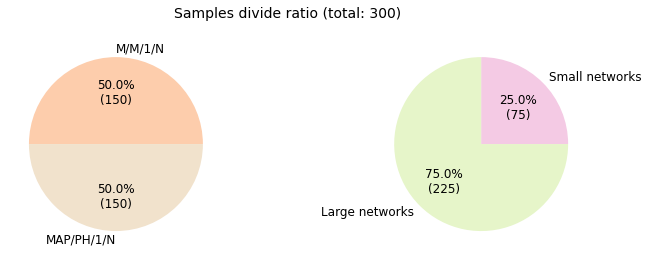

In [86]:
BASIC_NET = input_data[input_data.intype == "basic"]
GENERIC_NET = input_data[input_data.intype == "generic"]
SMALL_NET = input_data[input_data.small == True]
LARGE_NET = input_data[input_data.small == False]

def plot_inputs_pies():
    fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), ncols=2)
    size = 0.3
    values = [[len(BASIC_NET), len(GENERIC_NET)], 
              [len(SMALL_NET), len(LARGE_NET)]]
    outer_colors = [LIGHT_CMAP(0.2), LIGHT_CMAP(0.8)]
    inner_colors = [LIGHT_CMAP(0.4), LIGHT_CMAP(0.6)]
    
    def label_fun(pct, allvals):
        absolute = int(round(pct/100.*np.sum(allvals)))
        return "{:.1f}%\n({:d})".format(pct, absolute)
    
    textprops = {'fontsize': 12}
    
    ax1.pie(values[0], colors=outer_colors,
           autopct=lambda pct: label_fun(pct, values[0]),
           labels=['M/M/1/N', 'MAP/PH/1/N'],
           textprops=textprops)
    
    ax2.pie(values[1], colors=inner_colors,           
           autopct=lambda pct: label_fun(pct, values[1]),
           labels=['Small networks', 'Large networks'],
           textprops=textprops)

    fig.suptitle(f'Samples divide ratio (total: {len(input_data)})', fontsize=14)
    
plot_inputs_pies()

Посмотрим, что получилось. Для этого изобразим разброс значений входных параметров для каждого типа входа.

In [87]:
def _plot_input_scatter(df, axes, offset: float = 0.0, marker='o', color='black'):
    ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axes
    
    scatter_kwargs = {
        'marker': marker,
        'alpha': 0.5,
        's': df.capacity*30,
        'color': color,
    }
    
    ax1.scatter(df.net_size - 1 + offset, df.busy, **scatter_kwargs)
    ax2.scatter(df.net_size - 1 + offset, df.capacity, **scatter_kwargs)
    ax3.scatter(df.net_size - 1 + offset, df.arrival_cv, **scatter_kwargs)
    ax4.scatter(df.net_size - 1 + offset, df.service_cv, **scatter_kwargs)
    ax5.scatter(df.net_size - 1 + offset, df.arrival_skew, **scatter_kwargs)
    ax6.scatter(df.net_size - 1 + offset, df.service_skew, **scatter_kwargs)
    ax7.scatter(df.net_size - 1 + offset, df.arrival_lag1, **scatter_kwargs)
    
    
def plot_input_scatter():
    """
    Show scatter plots for inputs.
    """
    fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(24, 8), sharex=True,
                             gridspec_kw = {'height_ratios':[2,1,1,1]})
    ax11, ax12, ax13, ax14, ax15, ax16, ax17 = axes[0]
    ax21, ax22, ax23, ax24, ax25, ax26, ax27 = axes[1]
    
    color_small = get_color(0, 'Dark2')
    color_generic = get_color(0.33, 'Dark2')
    color_basic = get_color(0.66, 'Dark2')
    color_all = get_color(1.0, 'Dark2')
    
    _plot_input_scatter(SMALL_NET, axes[0], -0.25, marker='o', color=color_small)
    _plot_input_scatter(GENERIC_NET, axes[0], 0.0, marker='o', color=color_generic)
    _plot_input_scatter(BASIC_NET, axes[0], +0.25, marker='o', color=color_basic)    
    
    columns = ['busy', 'capacity', 'arrival_cv', 'service_cv', 'arrival_skew', 
               'service_skew', 'arrival_lag1']
    
    n_all = len(input_data)
    n_small = len(SMALL_NET)
    n_generic = len(GENERIC_NET)
    
    small_vs_all = pd.concat([
        pd.concat([input_data, pd.Series(['Any']*n_all, name='Network size')], axis=1),
        pd.concat([SMALL_NET, pd.Series(['Small']*n_small, name='Network size')], axis=1),
    ], ignore_index=True)
    
    for col, ax1, ax2, ax3 in zip(columns, axes[1], axes[2], axes[3]):
        sns.violinplot(data=input_data, x='net_size', y=col, ax=ax1, bw=.2,
                       color=color_all, inner="quartile", cut=True)
        sns.violinplot(data=SMALL_NET, x='net_size', y=col, ax=ax2, bw=.2, split=True,
                       color=color_small, inner="quartile", cut=True)
        sns.violinplot(data=GENERIC_NET, x='net_size', y=col, ax=ax3, bw=.2, split=True,
                       color=color_generic, inner="quartile", cut=True)
    
    y_labels = [r'$\lambda / \mu$', 'Емкость', r'$c_a$', r'$c_s$', r'$\gamma_a$', 
                r'$\gamma_s$', 'lag-1']
    
    for j in range(len(axes[0])):
        axes[0][j].set_title(y_labels[j])
        axes[-1][j].set_xlabel('Размер сети', fontsize=14)

    for i, j in product(range(4), range(7)):
        if i > 0:
            axes[i][j].grid()
        if i < 3:
            axes[i][j].set_xlabel('')
        axes[i][j].set_ylabel('')
    
    fig.legend(handles=[
        Line2D([0], [0], color=color_small, lw=4, label='Сети малого размера'),
        Line2D([0], [0], color=color_generic, lw=4, label='Сети с узлами MAP/PH/1/N'),
        Line2D([0], [0], color=color_basic, lw=4, label='Сети с узлами M/M/1/N'),
        Line2D([0], [0], color=color_all, lw=4, label='Все сети'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color_all, markersize=10, lw=4, label='Маленькая емкость очереди'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color_all, markersize=20, lw=4, label='Большая емкость очереди'),
    ], bbox_to_anchor=(0.7, 0.0), fontsize=14, ncol=3)
    
    fig.suptitle("Разброс значений входных параметров", fontsize=16)

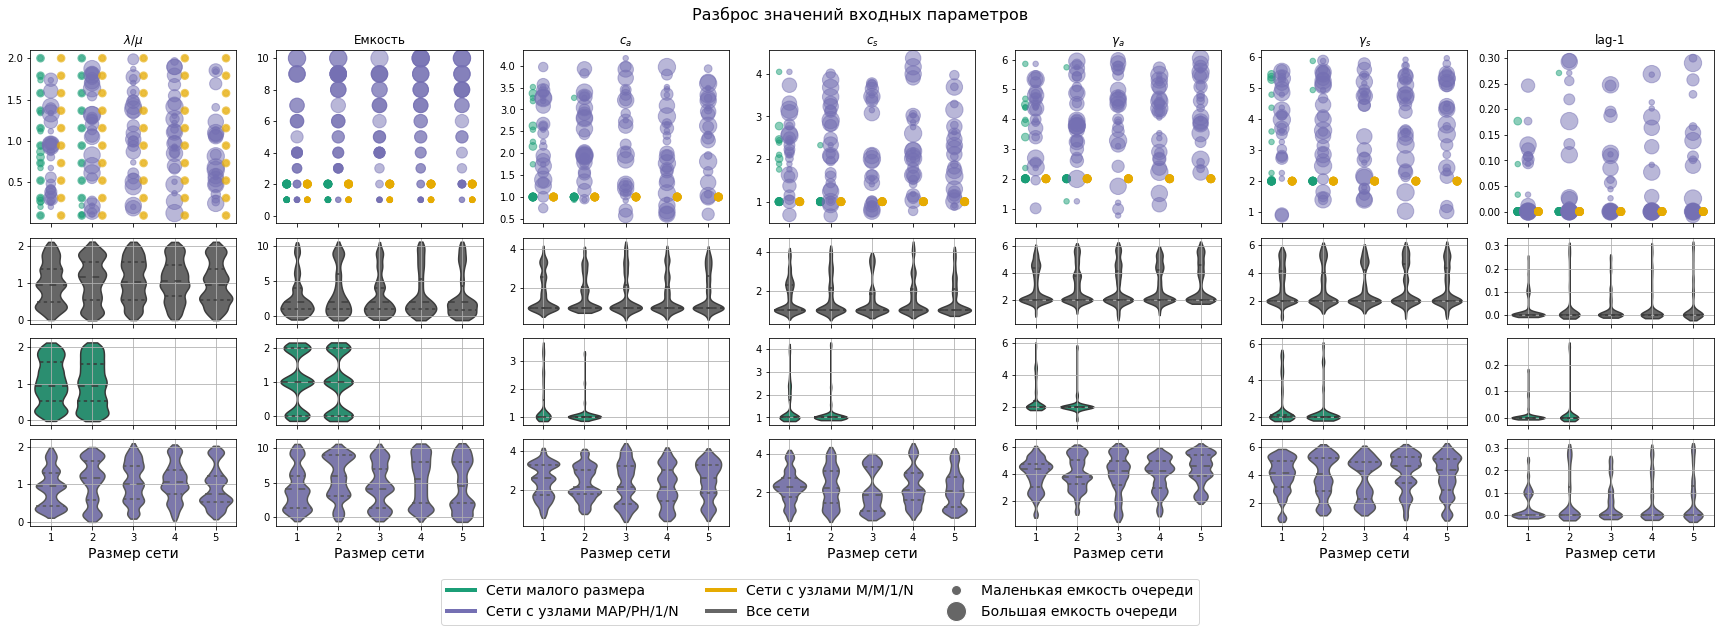

In [88]:
plot_input_scatter()
plt.tight_layout()
plt.show()

## Расчеты характеристик систем

Мы проведем несколько вариантов расчетов:

1. Точный расчет (только на тех сетях, на которых либо `small == True`, либо `intype == "basic"`)
2. Аппроксимацию выходящих потоков по трем моментам и коэффициенту автокорреляции с лагом 1
3. Аппроксимацию выходящих потоков по трем моментам без автокорреляции
4. Аппроксимацию выходящих потоков по первому моменту (то есть замену выходящих потоков Пуассоновским процессом)
5. Аппроксимацию и выходящих потоков, и входящего потока процессом Пуассона
6. Расчет с помощью метода Монте-Карло.

Заметим, что в случае (4) мы переходим от $MAP/PH/1/N$ на второй и последующих фазах к $M/PH/1/N$:
$$
\begin{aligned}
&MAP/PH/1/N \rightarrow MAP/PH/1/N \rightarrow \dots \rightarrow MAP/PH/1/N \Longrightarrow\\
&\qquad MAP/PH/1/N \rightarrow M/PH/1/N \rightarrow \dots \rightarrow M/PH/1/N
\end{aligned}
$$

А в случае (5) делаем еще более "смелую" замену:
$$
\begin{aligned}
&MAP/PH/1/N \rightarrow MAP/PH/1/N \rightarrow \dots \rightarrow MAP/PH/1/N \Longrightarrow\\
&\qquad M/PH/1/N \rightarrow M/PH/1/N \rightarrow \dots \rightarrow M/PH/1/N
\end{aligned}
$$

Для каждого метода мы будем анализировать три характеристики:

- среднюю межконцевую задержку (`delay`)
- среднюю вероятность доставки (`delivery_prob`)
- средний размер системы на последней фазе (`last_system_size`)
- сколько времени ушло на расчет (`elapsed`)

### Определение итерационной процедуры расчета

Для методов с аппроксимациями (2)-(5) также будем анализировать, насколько мы ошибаемся в оценке первых трех моментов и автокорреляции:

- максимальная ошибка в оценке среднего значения выходящего потока (`m1_err`)
- максимальная ошибка в оценке коэффициента вариации выходящего потока (`cv_err`)
- максимальная ошибка в оценке коэффициента асимметрии выходящего потока (`skew_err`)
- максимальная ошибка в оценке коэффициента автокорреляции с лагом 1 выходящего потока (`lag1_err`)

In [142]:
@dataclass
class SolveResults:
    skipped: bool
    delay: Optional[float] = None
    delivery_prob: Optional[float] = None
    last_system_size: Optional[float] = None
    elapsed: Optional[float] = None
    max_inp_order: Optional[int] = None
    max_out_order: Optional[int] = None
    m1_err: Optional[float] = None
    cv_err: Optional[float] = None
    skew_err: Optional[float] = None
    lag1_err: Optional[float] = None
        
    def update_m1_err(self, x: float):
        if self.m1_err is None or self.m1_err < x:
            self.m1_err = x
    
    def update_cv_err(self, x: float):
        if self.cv_err is None or self.cv_err < x:
            self.cv_err = x
    
    def update_skew_err(self, x: float):
        if self.skew_err is None or self.skew_err < x:
            self.skew_err = x
    
    def update_lag1_err(self, x: float):
        if self.lag1_err is None or self.lag1_err < x:
            self.lag1_err = x


def rel_err(x1, x2):
    if abs(x2) > 1e-6:
        return abs(x1 - x2) / abs(x2)
    return abs(x1) / (1 + abs(x2))

Так как все методы, кроме последнего, подразумевают использование итерационной процедуры, сначала определим ее.

In [162]:
def solve_iterative(inp, reducer=None, reduce_arrival=False) -> SolveResults:
    """
    Solve MAP/PH/1/N -> */PH/1/N -> ... */PH/1/N model analytically.
    
    If `reducer` is not None, then this function is applied
    to each departure process prior to sending it to the arrival to the
    next station.
    
    If `reduce_arrival = True`, then `reducer()` is applied
    to the first arrival as well (`inp.arrival`).
    
    Parameters
    ----------
    inp : row of DataFrame
        assumed that `inp` has at least `arrival`, `service`,
        `net_size` and `capacity` fields.
    reducer : None or Callable[[MarkovArrival], MarkovArrival]
        if not None, this function is applied to each departure
    reduce_arrival : bool, optional (default: False)
        if True, reduce arrival process as well
    
    Returns
    -------
    SolveResults
    """
    is_precise = reducer is None
    
    # Для точного решения (без аппроксимации выходных потоков)
    # мы используем только те входы, которые либо простые (экспоненты
    # на входе и обслуживании), либо небольшого размера.
    if is_precise and not inp.small and inp.intype != "basic":
        return SolveResults(skipped=True)
    
    # Замеряем начало выполнения
    t_start = perf_counter()
    solution = SolveResults(
        skipped=False, delay=0.0, delivery_prob=1.0, m1_err=0.0, 
        cv_err=0.0, skew_err=0.0, lag1_err=0.0, max_inp_order=0,
        max_out_order=0)
    
    # Если нужно предобработать входной поток, делаем это
    if reduce_arrival:
        arrival = reducer(inp.arrival)
        solution.m1_err = rel_err(arrival.mean, inp.arrival.mean)
        solution.cv_err = rel_err(arrival.cv, inp.arrival.cv)
        solution.skew_err = rel_err(arrival.skewness, inp.arrival.skewness)
        solution.lag1_err = rel_err(arrival.lag(1), inp.arrival.lag(1))
    else:
        arrival = inp.arrival
    
    # Итерационно рассчитываем характеристики сети
    solution.max_inp_order = arrival.order
    sta_index = 0
    while sta_index < inp.net_size:
        # Обновляем, если надо, максимальный размер входа:
        solution.max_inp_order = max(solution.max_inp_order, arrival.order)
        
        # Строим очередной узел        
        system = MapPh1NQueue(arrival, inp.service, inp.capacity)
        dep = system.departure
        
        # Рассчитываем и накапливаем задержку, вероятность доставки
        # и обновляем размер системы.
        solution.delay += system.response_time
        solution.delivery_prob *= 1 - system.loss_prob
        solution.last_system_size = system.system_size.mean
        solution.max_out_order = max(solution.max_out_order, dep.order)
        
        # Если нужно аппроксимировать выход, делаем это.
        # Иначе используем выход в качестве нового входа.
        if reducer is not None:
            arrival = reducer(dep)
            solution.update_m1_err(rel_err(arrival.mean, dep.mean))
            solution.update_cv_err(rel_err(arrival.cv, dep.cv))
            solution.update_skew_err(rel_err(arrival.skewness, dep.skewness))
            solution.update_lag1_err(rel_err(arrival.lag(1), dep.lag(1)))
        else:
            arrival = system.departure
        
        # Переходим к следующей станции
        sta_index += 1
    
    # Замеряем время завершения
    solution.elapsed = perf_counter() - t_start
    return solution

Применять итерационную процедуру мы будем однотипно:

1. Выполняем процедуру с теми или иным аргументами `reducer` и `reduce_arrival`, результаты записываем в колонку `__solve_ret`
2. Растаскиваем результаты по отдельным колонками. У колонок будут названия с префиксами, зависящими от метода, и окончаниями такими же, как названия полей (например, `precise_delay`)
3. Удаляем служебную колонку `__solve_ret`

Названия префиксов будут:

1. `precise` - точный метод
2. `approx_map` - аппроксимация MAP-потоками (по 3 моментам и лагу)
3. `approx_ph3` - аппроксимация PH-распределениями (по 3 моментам)
4. `approx_ph1` - аппроксимация выходов потоками Пуассона
5. `approx_mm1` - аппроксимация потоками Пуассона всех входящих и выходящих процессов

In [103]:
def apply_iterative_solution(
        df: pd.DataFrame, 
        prefix: str, 
        reducer = None, 
        reduce_arrival: bool = False) -> pd.DataFrame:
    """
    Apply `solve_iteartive()` to each row in the DataFrame.
    Return an updated DataFrame with columns like `prefix_metric`.
    """
    if not FORCE_COMPUTE:
        print("skipping, set FORCE_COMPUTE = True to enable.")
        return df
        
    df['__ret'] = df.progress_apply(
        lambda inp: solve_iterative(
            inp, 
            reducer=reducer, 
            reduce_arrival=reduce_arrival),
        axis=1)

    fields = ['skipped', 'delay', 'delivery_prob', 'last_system_size',
              'elapsed', 'max_inp_order', 'max_out_order', 
              'm1_err', 'cv_err', 'skew_err', 'lag1_err']
    
    for field in fields:
        df[f'{prefix}_{field}'] = df.apply(
            lambda row: getattr(row['__ret'], field), axis=1)

    return df.drop(['__ret'], axis=1)

### Точный расчет

Начнем с выполнения точного расчета.

In [145]:
input_data = apply_iterative_solution(input_data, prefix='precise')

  0%|          | 0/300 [00:00<?, ?it/s]

In [146]:
def plot_solution_stats(df, prefix):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 6))
    sns.kdeplot(ax=axes[0][0], data=df, x=f'{prefix}_delay', fill=True)
    sns.kdeplot(ax=axes[0][1], data=df, x=f'{prefix}_delivery_prob', fill=True)
    sns.kdeplot(ax=axes[0][2], data=df, x=f'{prefix}_last_system_size', fill=True)
    sns.kdeplot(ax=axes[1][0], data=df, x=f'{prefix}_elapsed', fill=True)
    
    sns.kdeplot(ax=axes[1][1], data=df, x=f'{prefix}_max_inp_order', fill=True, label="Max. inp. order")
    sns.kdeplot(ax=axes[1][1], data=df, x=f'{prefix}_max_out_order', fill=True, label="Max. out. order")
    
    g = sns.boxplot(ax=axes[1][2], x="variable", y="value",
                data=pd.melt(df[[
                    f'{prefix}_m1_err', f'{prefix}_cv_err',
                    f'{prefix}_skew_err', f'{prefix}_lag1_err'
                ]]), fliersize=0)
    g.set_xticklabels(['m1_err', 'cv_err', 'skew_err', 'lag1_err'], rotation=45)
    axes[1][2].set_xlabel('')
    axes[1][2].set_ylabel('')
    axes[1][1].legend()

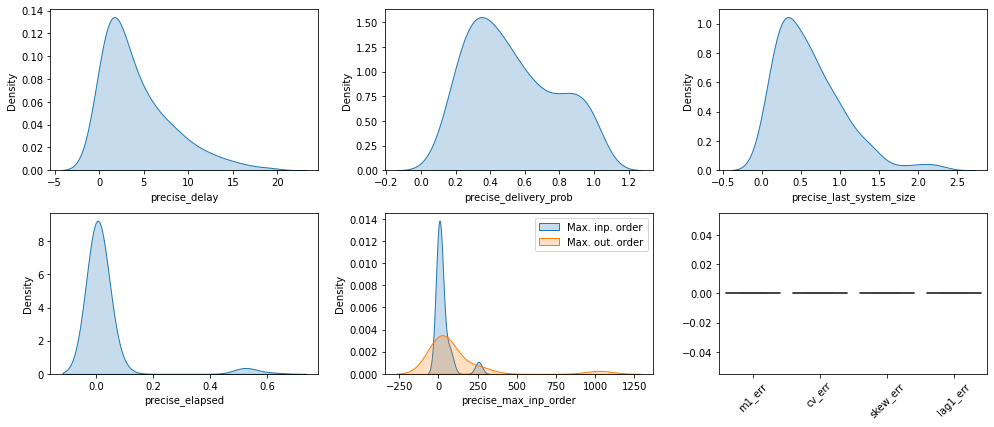

In [147]:
plot_solution_stats(input_data[input_data.precise_skipped == False], 'precise')
plt.tight_layout()
plt.show()

In [149]:
input_data['precise_delivery_prob'].describe()

count    165.000000
mean       0.525436
std        0.249550
min        0.132395
25%        0.318681
50%        0.466667
75%        0.695687
max        0.999100
Name: precise_delivery_prob, dtype: float64

In [150]:
input_data['precise_elapsed'].describe()

count    165.000000
mean       0.031144
std        0.108425
min        0.000516
25%        0.001188
50%        0.002887
75%        0.006593
max        0.618701
Name: precise_elapsed, dtype: float64

## Вычисление характеристик с помощью аппроксимации выходящих потоков

Мы будем рассматривать три варианта:

- апрроксимацию по трем моментам и коэффициенту автокорреляции
- аппроксимацию по трем моментам и нулевой автокорреляции
- аппроксимацию по первому моменту ($M/PH/1/N$)


In [155]:
def fit_departure(departure: MarkovArrival, use_lag: bool, only_mean: bool) -> MarkovArrival:
    mean = departure.mean
    if only_mean:
        ph = PhaseType.exponential(1 / mean)
    else:
        moments = [departure.moment(i) for i in range(1, 4)]
        try:
            ph = fit_acph2(moments, strict=True)[0]
        except BoundsError:
            dist = fit_mern2(moments, strict=False)[0]
            ph = dist.as_ph()
    # Fit lag, if needed:
    if use_lag:
        arrival = fit_map_horvath05(ph, departure.lag(1))[0]
    else:
        arrival = MarkovArrival.phase_type(ph.s, ph.p)
    return arrival

#### Замена всех MAP экспонентами

In [163]:
input_data = apply_iterative_solution(
    input_data, 
    prefix='approx_mm1', 
    reducer=lambda marp: fit_departure(marp, use_lag=False, only_mean=True),
    reduce_arrival=True)

  0%|          | 0/300 [00:00<?, ?it/s]

/home/andrey/workspace/pyqumo/.venv/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


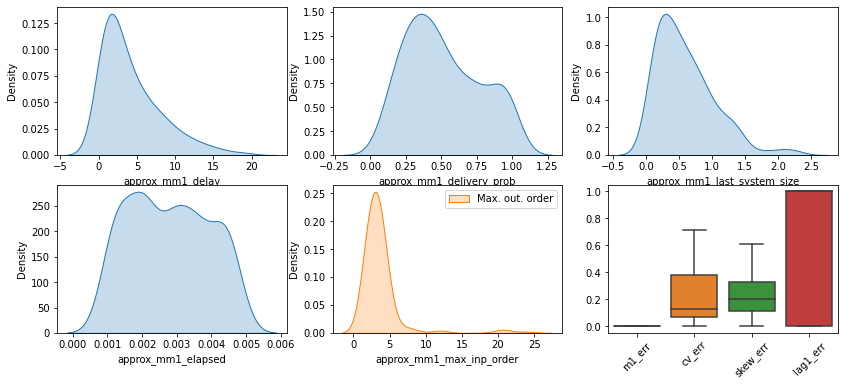

In [165]:
plot_solution_stats(input_data[input_data.precise_skipped == False], 'approx_mm1')

#### Замена выходящих MAP экспонентами

In [158]:
input_data = apply_iterative_solution(
    input_data, 
    prefix='approx_ph1', 
    reducer=lambda marp: fit_departure(marp, use_lag=False, only_mean=True),
    reduce_arrival=False)

  0%|          | 0/300 [00:00<?, ?it/s]

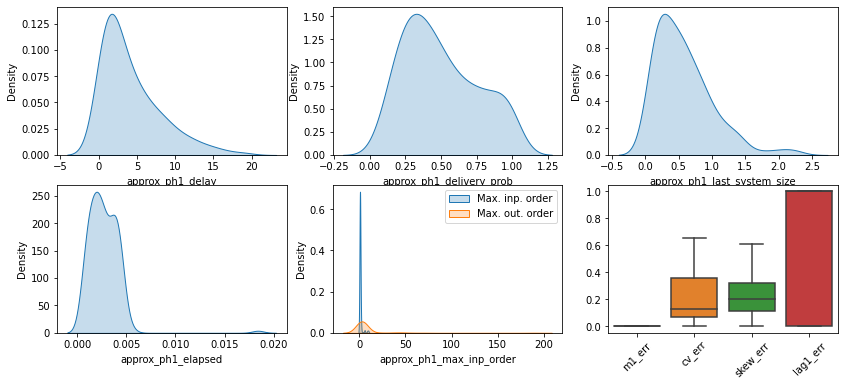

In [168]:
plot_solution_stats(input_data[input_data.precise_skipped == False], 'approx_ph1')

#### Замена выходящих MAP по трем моментам

In [166]:
input_data = apply_iterative_solution(
    input_data, 
    prefix='approx_ph3', 
    reducer=lambda marp: fit_departure(marp, use_lag=False, only_mean=False),
    reduce_arrival=False)

  0%|          | 0/300 [00:00<?, ?it/s]

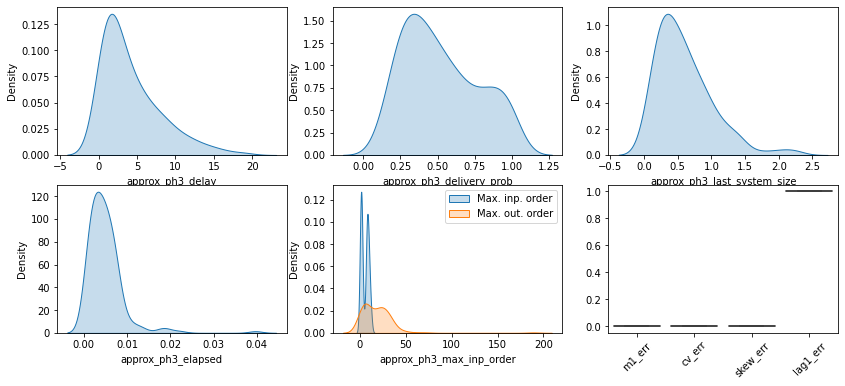

In [169]:
plot_solution_stats(input_data[input_data.precise_skipped == False], 'approx_ph3')

#### Замена выходящих MAP по трем моментам и коэффициенту автокорреляции с лагом 1

In [170]:
input_data = apply_iterative_solution(
    input_data, 
    prefix='approx_map', 
    reducer=lambda marp: fit_departure(marp, use_lag=True, only_mean=False),
    reduce_arrival=False)

  0%|          | 0/300 [00:00<?, ?it/s]

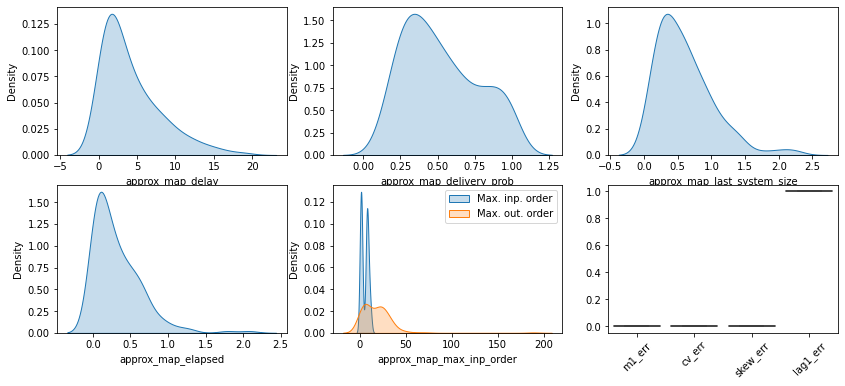

In [172]:
plot_solution_stats(input_data[input_data.precise_skipped == False], 'approx_map')